<a href="https://colab.research.google.com/github/mk7890/Machine-Learning-II/blob/main/ML2_TimeSeriesAnalysis_California_Births.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

Loading the Dataset

In [ ]:
!kaggle datasets download -d dougcresswell/daily-total-female-births-in-california-1959

Dataset URL: https://www.kaggle.com/datasets/dougcresswell/daily-total-female-births-in-california-1959
License(s): other
daily-total-female-births-in-california-1959.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import zipfile
zipfile_path = '/content/daily-total-female-births-in-california-1959.zip'
csv_file = zipfile_path.replace('zip', '')
with zipfile.ZipFile(zipfile_path, 'r') as file:
  file.extractall()
  print('Done')

Done


In [ ]:
data = pd.read_csv("/content/daily-total-female-births-CA.csv")
data.head()

,date,births
0,1959-01-01,35
1,1959-01-02,32
2,1959-01-03,30
3,1959-01-04,31
4,1959-01-05,44


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    365 non-null    object
 1   births  365 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.8+ KB


In [ ]:
data.describe()

,births
count,365.000000
mean,41.980822
std,7.348257
min,23.000000
25%,37.000000
50%,42.000000
75%,46.000000
max,73.000000


In [ ]:
data.columns

Index(['date', 'births'], dtype='object')

#TIME SERIES ANALYSIS

- Data collection
- Cleaning (check datatypes, missing values, set frequency)
- Set date time column as index
- Visualizations
- Checking for Stationarity & Differencing (ADF check: P_value>0.05)

If data is non-stationary(perform detrending, differencing, transforming)

Models like Arima, Sarimax... transform non-stationary data automatically

- Decomposing time series (trend, seasonality, cyclic, noise/residuals)

change frequency to years, months, weeks, days as needed

apply smoothing(SMA, SES(weight), DES(trend), TES(seasonality)) techniques if data is noisy and difficult to pick-out patterns

- Train Test split data
- ACF & PACF plot : Autocorrealtive function(how lags move), Partial Autocorrelative function(how first lag affects the second....)
- Modelling (AIC, BIC, ) AIC & BIC should be low
Models: p(autoregressive lags), d(difference in the order), q(moving average lags)

AR(1,0,0), MA(0,0,1), ARMA(1,0,1), ARIMA(1,1,1), SARIMA(1,0,1, seasonality), SARIMAX(1,0,1, external_factors)
- Forecastine/predictions
- Visualizations
- Evaluate Model performance

In [ ]:
# Convert 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

In [ ]:
# Check for missing values
print("Missing values:\n", data.isnull().sum())

Missing values:
 date      0
births    0
dtype: int64


In [ ]:
# Set frequency (if known)
data = data.set_index('date').asfreq('D')  # Daily frequency assumed; adjust if needed

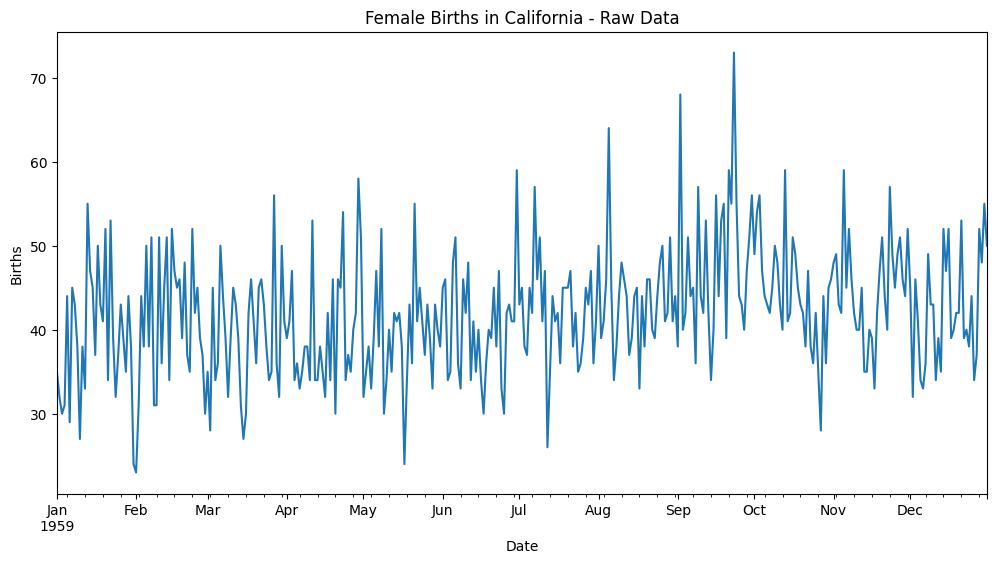

In [ ]:
# Step 3: Visualizations
plt.figure(figsize=(12, 6))
data['births'].plot(title='Female Births in California - Raw Data')
plt.xlabel('Date')
plt.ylabel('Births')
plt.show()

In [ ]:
# Checking for Stationarity & Differencing
def check_stationarity(series):
    result = adfuller(series.dropna())
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] > 0.05:
        print("The series is non-stationary.")
    else:
        print("The series is stationary.")


In [ ]:
print("\nChecking Stationarity:")
check_stationarity(data['births'])


Checking Stationarity:
ADF Statistic: -4.808291253559765
p-value: 5.2434129901498554e-05
Critical Values: {'1%': -3.448748905151901, '5%': -2.8696473721448728, '10%': -2.5710891239349585}
The series is stationary.


In [ ]:
# Differencing if non-stationary
if adfuller(data['births'].dropna())[1] > 0.05:
    data['births_diff'] = data['births'].diff()
    plt.figure(figsize=(12, 6))
    data['births_diff'].dropna().plot(title='Differenced Data')
    plt.show()

    print("\nChecking Stationarity after Differencing:")
    check_stationarity(data['births_diff'])

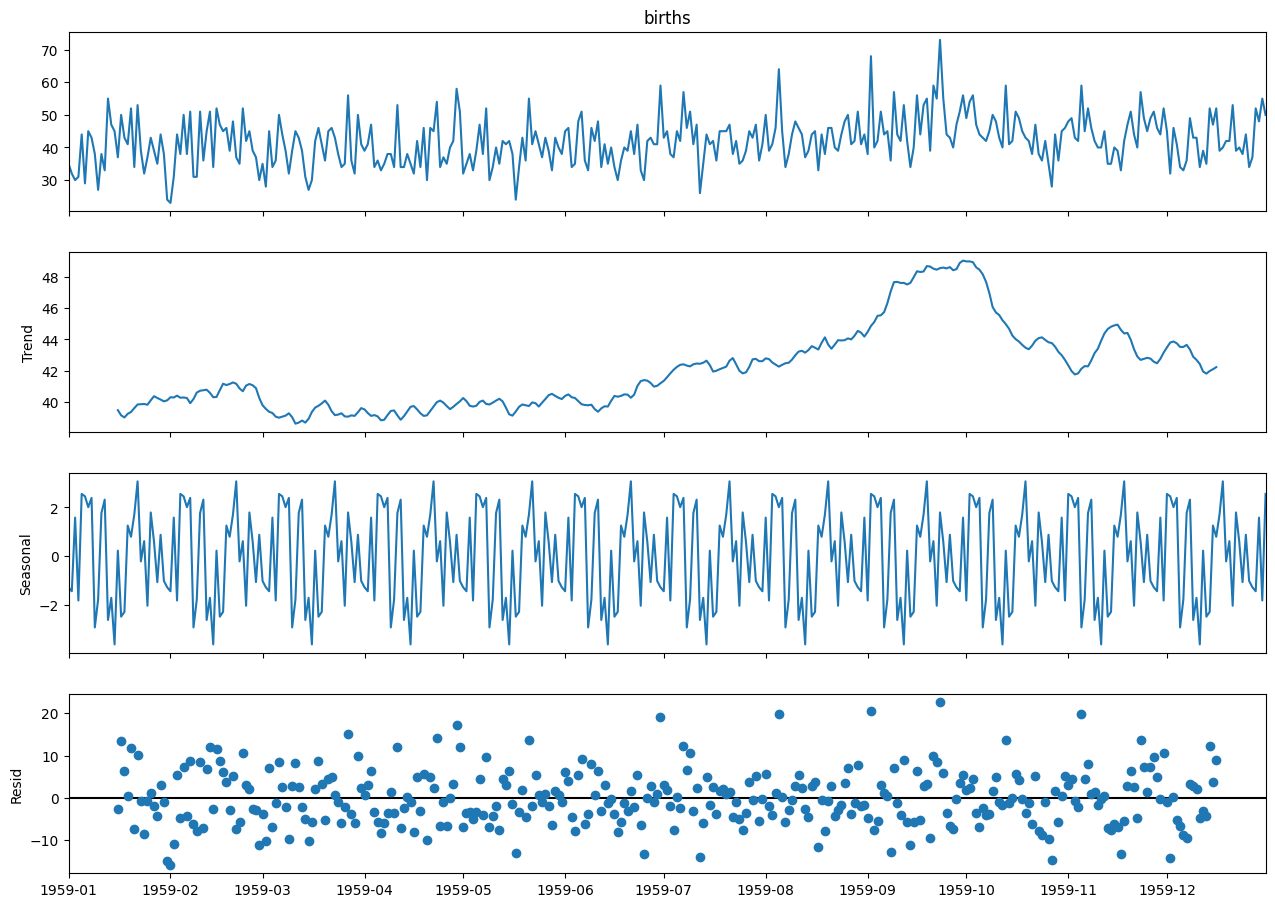

In [ ]:
# Decomposing Time Series with a specified seasonal period and adjusted figure size
decomposition = seasonal_decompose(data['births'], model='additive', period=30)

# Adjust figure size
fig = decomposition.plot()
fig.set_size_inches(14, 10)  # Width = 14 inches, Height = 10 inches
plt.show()


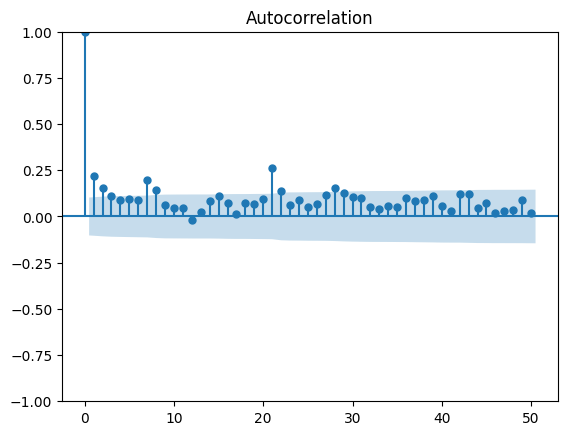

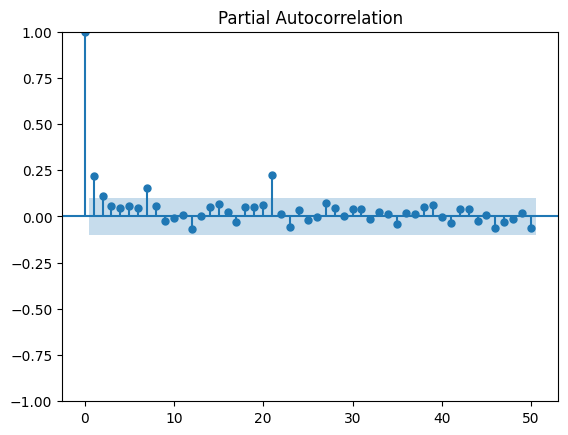

In [ ]:
#  ACF & PACF Plots
plot_acf(data['births'].dropna(), lags=50)
plt.show()

plot_pacf(data['births'].dropna(), lags=50)
plt.show()

In [ ]:
#  Train-Test Split
train = data.iloc[:-int(len(data) * 0.2)]
test = data.iloc[-int(len(data) * 0.2):]

Modelling

In [ ]:
# ARIMA Model
arima_model = ARIMA(train['births'], order=(2, 1, 2))  # Replace (p, d, q) as needed
arima_fit = arima_model.fit()
print(arima_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 births   No. Observations:                  292
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -985.074
Date:                Mon, 13 Jan 2025   AIC                           1980.149
Time:                        10:53:43   BIC                           1998.515
Sample:                    01-01-1959   HQIC                          1987.506
                         - 10-19-1959                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6368     61.620     -0.010      0.992    -121.410     120.136
ar.L2          0.0525      4.490      0.012      0.991      -8.748       8.853
ma.L1         -0.2461     61.625     -0.004      0.9

In [ ]:
# SARIMA Model
sarima_model = SARIMAX(train['births'], order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit()
print(sarima_fit.summary())

                                      SARIMAX Results                                       
Dep. Variable:                               births   No. Observations:                  292
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -960.323
Date:                              Mon, 13 Jan 2025   AIC                           1934.646
Time:                                      10:53:56   BIC                           1960.064
Sample:                                  01-01-1959   HQIC                          1944.842
                                       - 10-19-1959                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8083      0.521     -1.552      0.121      -1.829       0.212
ar.L2          0.08

In [ ]:
# Step 9: Forecasting
arima_forecast = arima_fit.forecast(steps=len(test))
sarima_forecast = sarima_fit.forecast(steps=len(test))

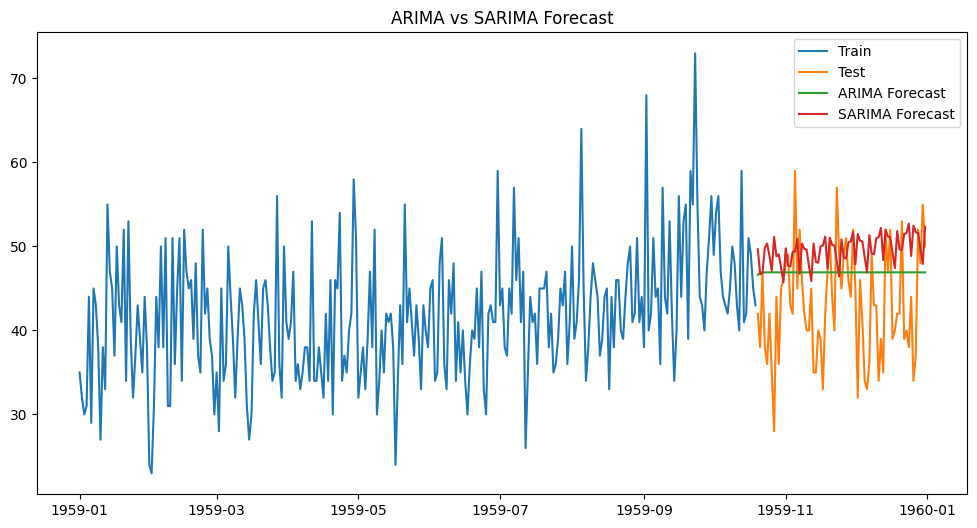

In [ ]:
# Step 10: Visualizations
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['births'], label='Train')
plt.plot(test.index, test['births'], label='Test')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast')
plt.legend()
plt.title('ARIMA vs SARIMA Forecast')
plt.show()


In [ ]:
# Step 11: Evaluate Model Performance
def evaluate_model(test, forecast, model_name):
    mae = mean_absolute_error(test, forecast)
    mse = mean_squared_error(test, forecast)
    rmse = np.sqrt(mse)
    print(f"{model_name} Performance:\nMAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

evaluate_model(test['births'], arima_forecast, "ARIMA")
evaluate_model(test['births'], sarima_forecast, "SARIMA")


ARIMA Performance:
MAE: 6.18, MSE: 56.37, RMSE: 7.51
SARIMA Performance:
MAE: 7.73, MSE: 89.90, RMSE: 9.48


In [1]:
!pip install prophet